# Tracking highly motile cells using flow field estimation and Ultrack

Tracking highly motile cells can be challenging.
Here, we show how you can estimate the cells' flow to assist in tracking motile cells.

For this purpose, we analyze the Tribolium Castaneum embryo 3D cartographic projection from the [cell tracking challenge (CTC)](http://celltrackingchallenge.net/3d-datasets); the cells in this dataset show a clear migration pattern, plus their movement are further amplified on the left and right edges of the image due to projection artifacts.

First, we download the data from the CTC website.

In [1]:
!wget -nc http://data.celltrackingchallenge.net/training-datasets/Fluo-N3DL-TRIC.zip
!unzip -n Fluo-N3DL-TRIC.zip

File ‘Fluo-N3DL-TRIC.zip’ already there; not retrieving.

Archive:  Fluo-N3DL-TRIC.zip


We import the required packages. You can install them using the conda environment file in this folder.

In [2]:
from pathlib import Path

import napari
import numpy as np
import pandas as pd
import dask.array as da
import scipy.ndimage as ndi
from napari.utils.notebook_display import nbscreenshot
from rich.pretty import pprint
from tifffile import imread

from traccuracy import run_metrics
from traccuracy.loaders import load_ctc_data
from traccuracy.matchers import CTCMatched
from traccuracy.metrics import CTCMetrics, DivisionMetrics

from ultrack import MainConfig, add_flow, segment, link, solve, to_tracks_layer, tracks_to_zarr, to_ctc
from ultrack.utils.array import array_apply, create_zarr
from ultrack.imgproc import robust_invert, detect_foreground
from ultrack.imgproc.flow import timelapse_flow, advenct_from_quasi_random, trajectories_to_tracks
from ultrack.utils.cuda import on_gpu
from ultrack.tracks.stats import tracks_df_movement

We set the download dataset path, open a napari viewer, and load the images using napari's default reader.

If preferred, you can restrict the analysis to the last 50 frames where the interesting part is. However, you won't be able to compute the accuracy since the ground-truth dimension won't match.

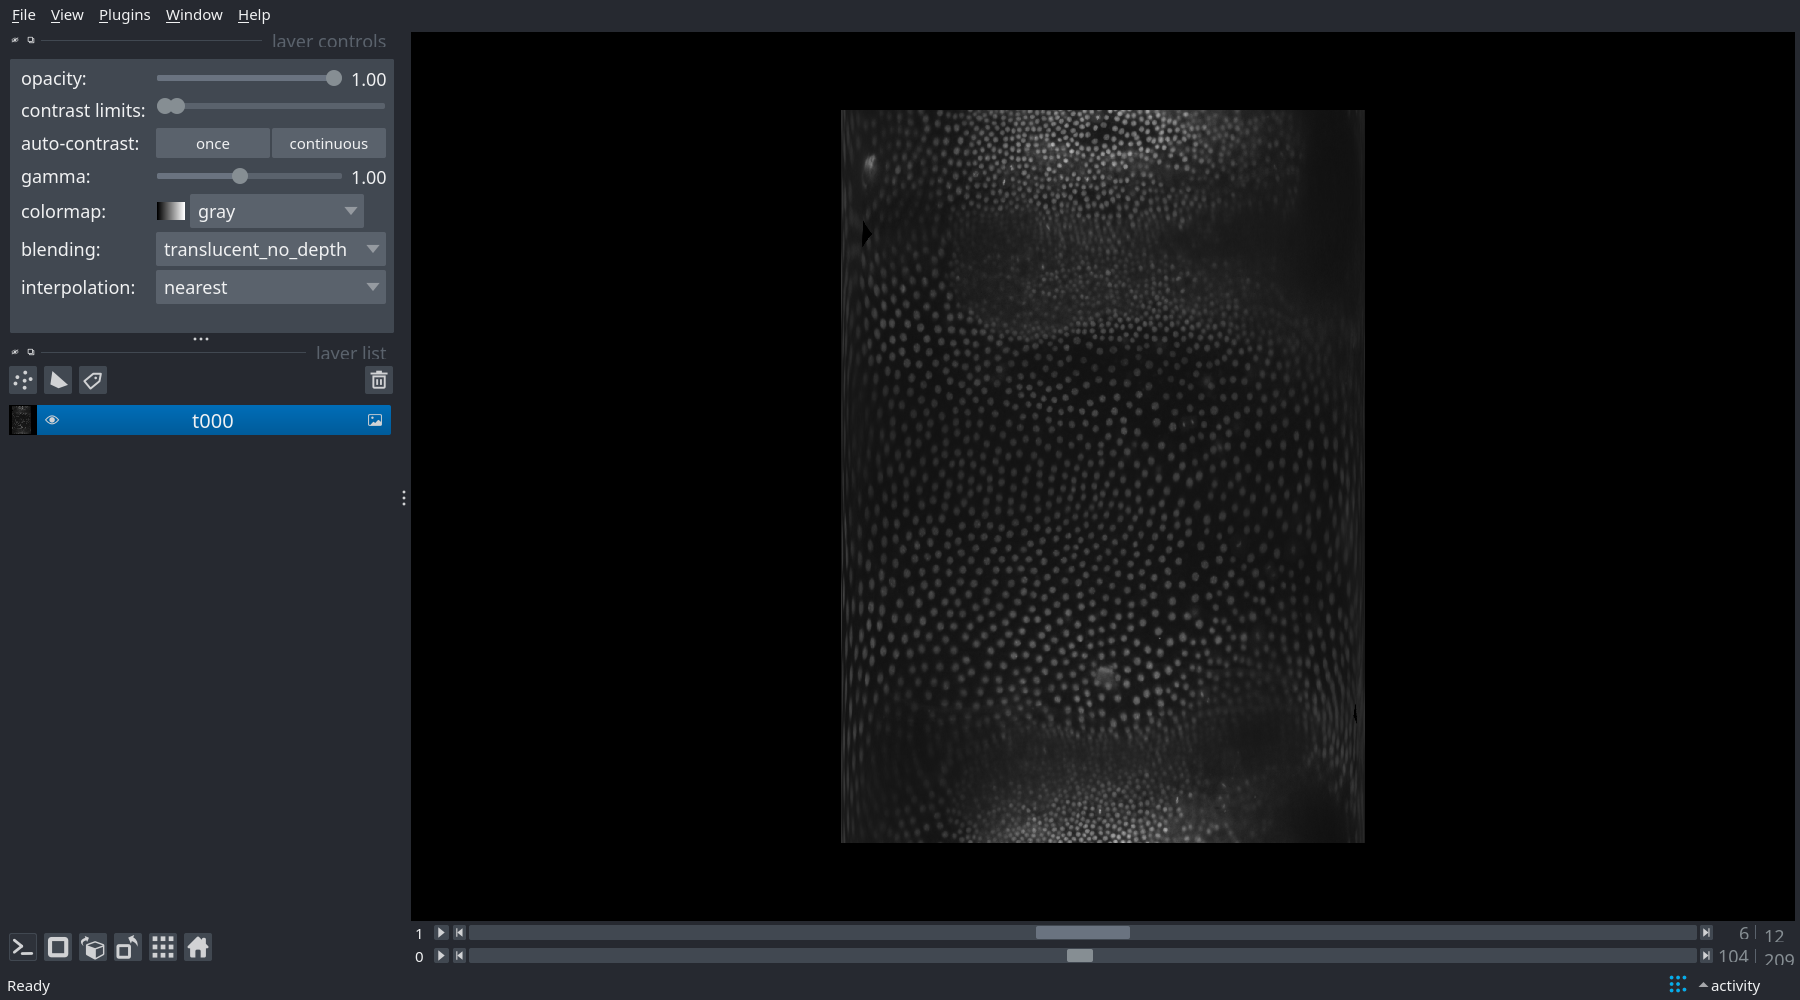

In [3]:
dataset_path = Path("Fluo-N3DL-TRIC/02")

# im_files = sorted(dataset_path.glob("*.tif"))[-50:]  # uncomment to run the last 50 frames
im_files = sorted(dataset_path.glob("*.tif"))  # uncomment to run the whole dataset

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)

im_layer = viewer.open(im_files, stack=True)
image = viewer.layers[0].data

nbscreenshot(viewer)

We detect which voxels contains cells and which are background using the `array_apply` function to apply the `detect_foreground` to each individual time point while saving it to the `detection.zarr` path.

Applying detect_foreground ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [05:54<00:00,  1.69s/it]


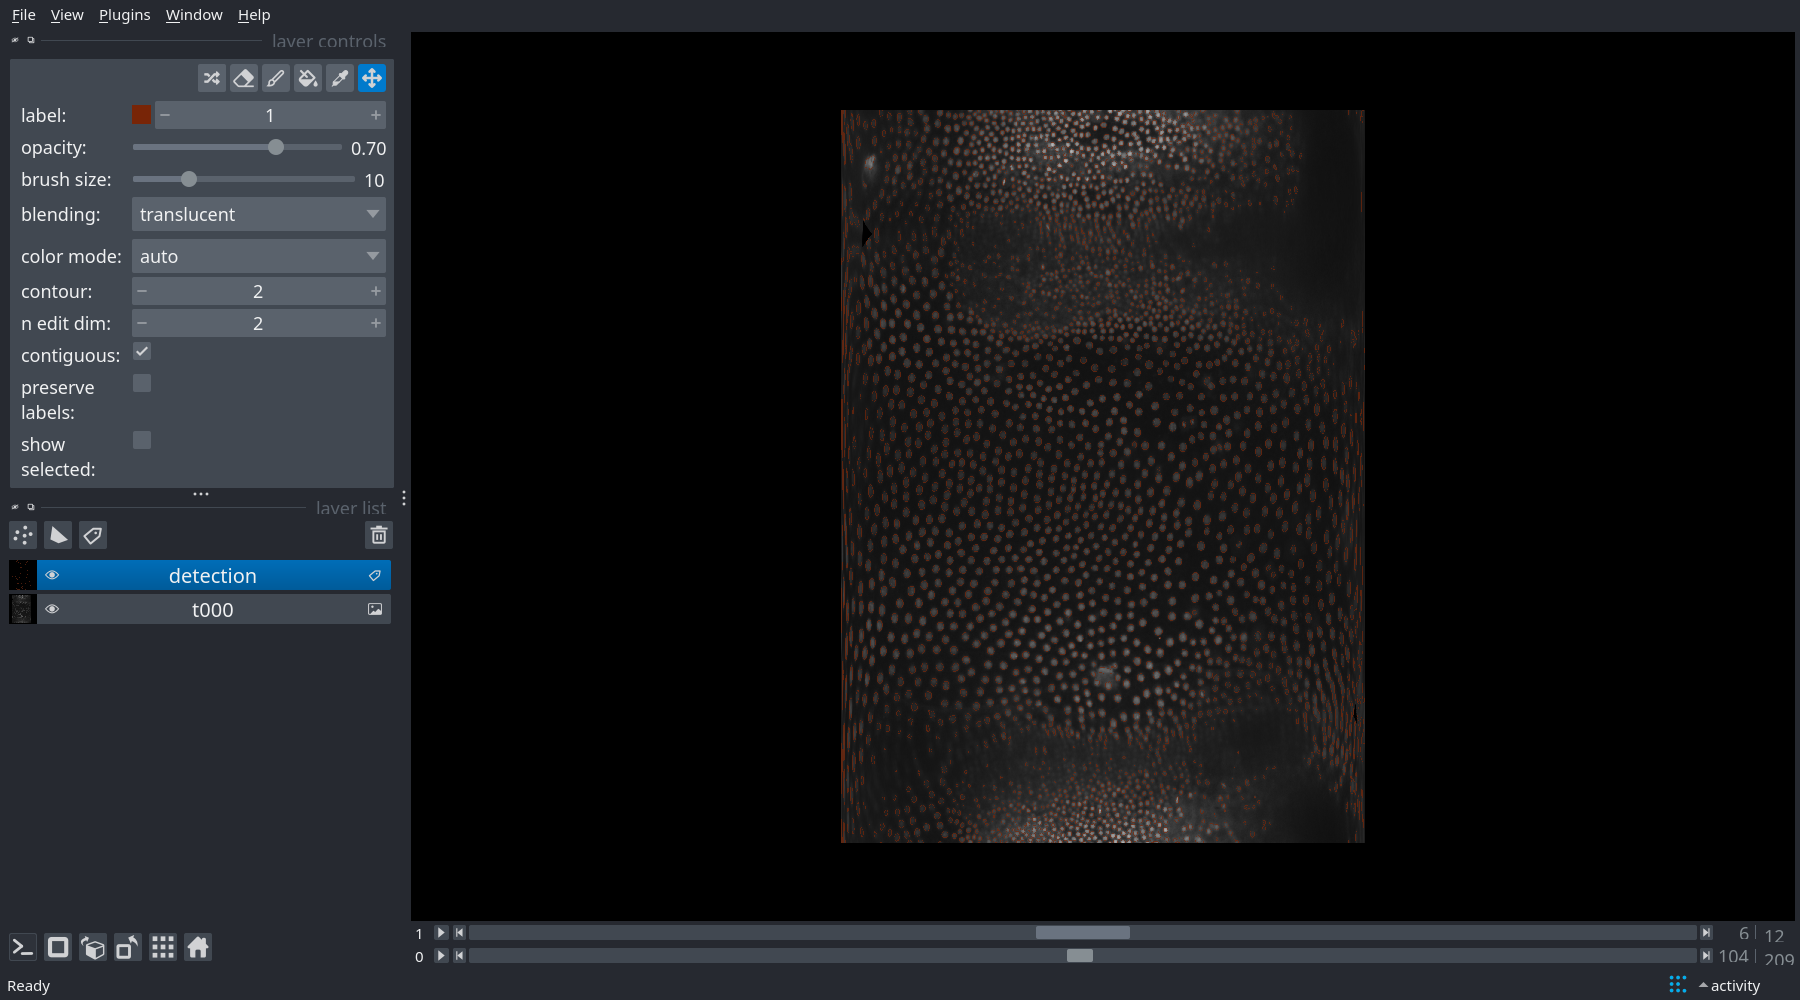

In [4]:
detection = create_zarr(image.shape, bool, "detection.zarr", overwrite=True)
array_apply(
    image,
    out_array=detection,
    func=on_gpu(detect_foreground),
)

viewer.add_labels(detection, visible=True).contour = 2

nbscreenshot(viewer)

Ultrack also requires an estimate of the cell boundaries, we approximate this by inverting the image using the `robust_invert` function and saving it to `boundaries.zarr`.

In [5]:
boundaries = create_zarr(image.shape, np.float16, "boundaries.zarr", overwrite=True)
array_apply(
    image,
    out_array=boundaries,
    func=on_gpu(robust_invert),
    sigma=3.0,
)

viewer.add_image(boundaries, visible=False)

Applying robust_invert ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [04:26<00:00,  1.27s/it]


<Image layer 'boundaries' at 0x7fd140f30310>

Using the original images we compute the movement flow. We use a lower number of `n_scales` because the `z` dimension is very short and using the default `n_scales=3` results in a zero-length dimension.

In [ ]:
!rm -r flow.zarr # removing previous flow
flow = timelapse_flow(image, store_or_path="flow.zarr", n_scales=2, lr=1e-2, num_iterations=2_000)
viewer.add_image(
    flow,
    contrast_limits=(-0.001, 0.001),
    colormap="turbo",
    visible=False,
    scale=(4,) * 3,
    channel_axis=1,
    name="flow field",
)

We advect random samples through the flow field and visualize them using the napari tracks layer to evaluate the flow. Plus, we color the tracks according to their angle on the xy-plane.

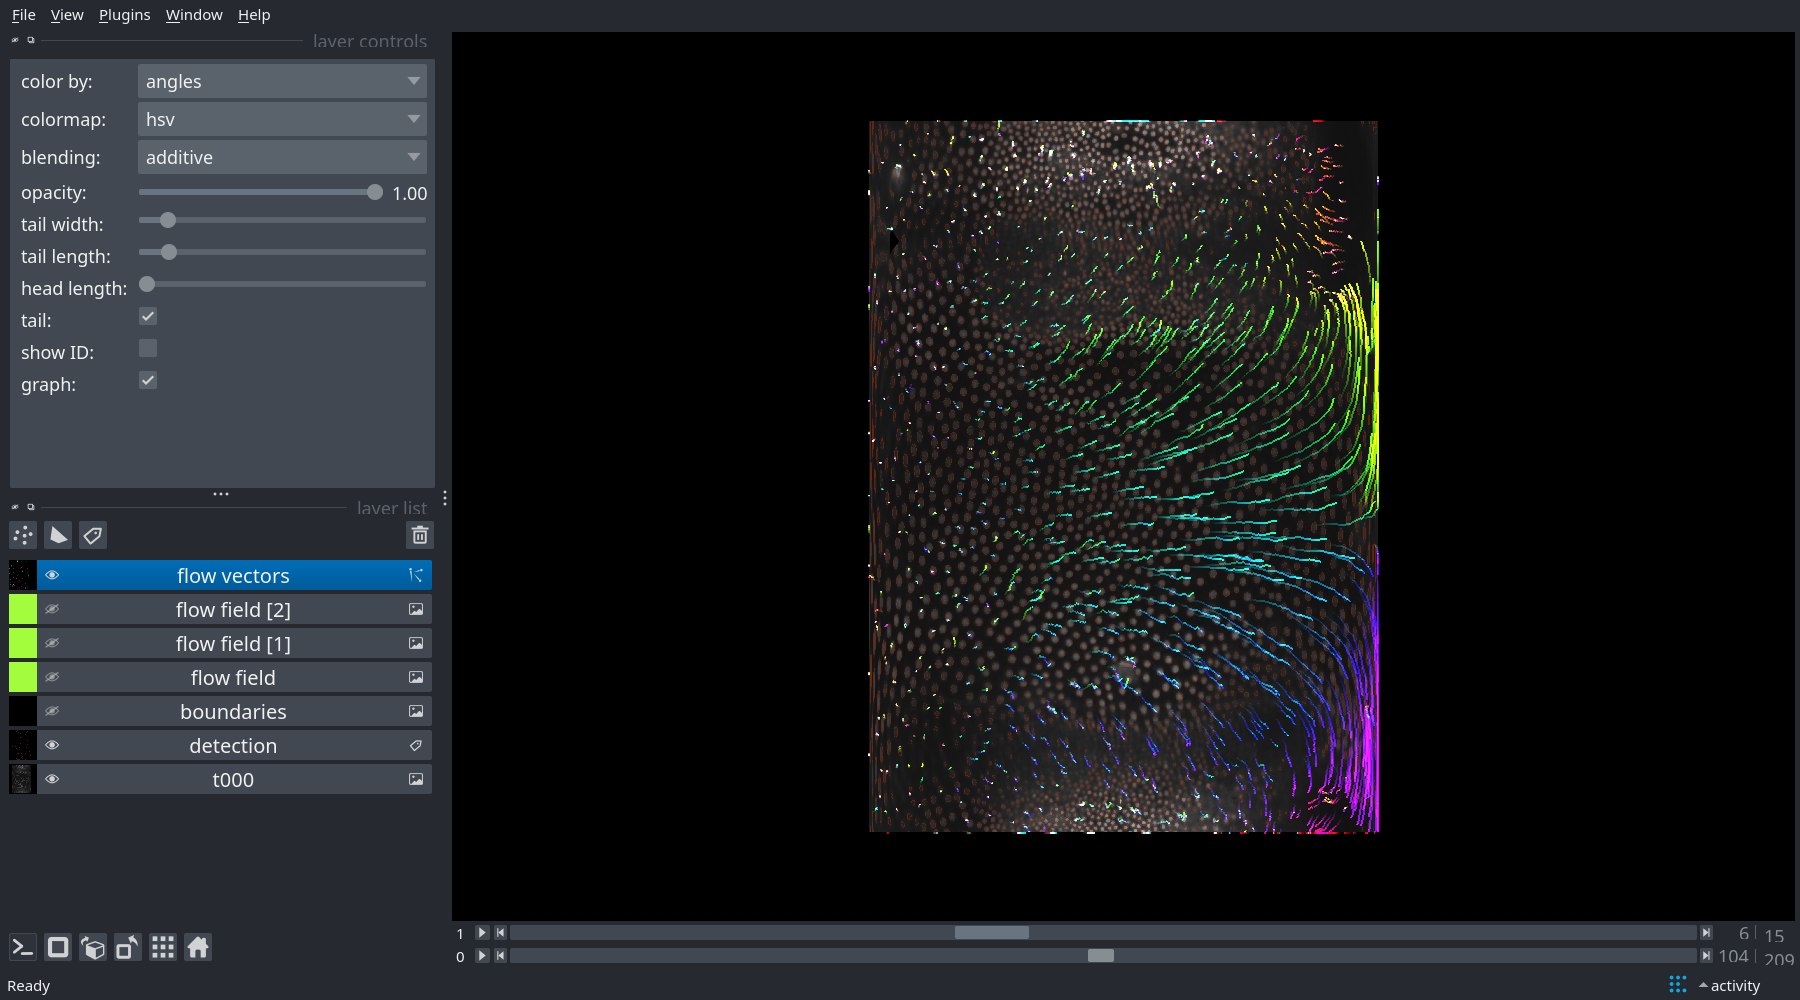

In [7]:
trajectory = advenct_from_quasi_random(flow, detection.shape[-3:], n_samples=1000)
flow_tracklets = pd.DataFrame(
    trajectories_to_tracks(trajectory),
    columns=["track_id", "t", "z", "y", "x"],
)
flow_tracklets[["z", "y", "x"]] += 0.5  # napari was crashing otherwise, might be an openGL issue
flow_tracklets[["dz", "dy", "dx"]] = tracks_df_movement(flow_tracklets)
flow_tracklets["angles"] = np.arctan2(flow_tracklets["dy"], flow_tracklets["dx"])

flow_tracklets.to_csv("flow_tracklets.csv", index=False)

viewer.add_tracks(
    flow_tracklets[["track_id", "t", "z", "y", "x"]],
    name="flow vectors",
    visible=True,
    tail_length=25,
    features=flow_tracklets[["angles", "dy", "dx"]],
    colormap="hsv",
).color_by="angles"

nbscreenshot(viewer)

Now that we have our `detection`, `boundaries` and `flow`, and have checked that they look ok, we will start the tracking step.
Ultrack's tracking **with flow** relies on 4 steps and their respective python functions:
- `segment`: Computes the segmentation hypothesis for tracking;
- `add_flow`: Adds the flow to each segmentation hypothesis, must be called before `link`;
- `link`: Links and assign edge weights to the segmentation hypothesis, taking into consideration the previously added flow;
- `solve`: Solves the tracking problem by selecting the strongly associated segmentation hypothesis.

These steps use our configuration object, `MainConfig`, which we'll set up below. Its documentation can be found [here](https://github.com/royerlab/ultrack/blob/main/ultrack/config/README.md).

The parameters were chosen manually by inspection.

NOTE: If you're running out of memory, you should decrease the `n_workers` parameters. If you want to speed up the processing and have spare memory, you can increase it.

We will evaluate the tracking accuracy in two scenarios, with and without flow.

In [8]:
cfg = MainConfig()

cfg.data_config.n_workers = 8

cfg.segmentation_config.n_workers = 8
cfg.segmentation_config.min_area = 250
cfg.segmentation_config.max_area = 15_000

cfg.linking_config.n_workers = 12
cfg.linking_config.max_neighbors = 5
cfg.linking_config.max_distance = 50.0
cfg.linking_config.distance_weight = 0.0001

cfg.tracking_config.window_size = 70
cfg.tracking_config.overlap_size = 5
cfg.tracking_config.appear_weight = -0.01
cfg.tracking_config.disappear_weight = -0.001
cfg.tracking_config.division_weight = 0

pprint(cfg)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=8),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=250,
│   │   max_area=15000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7fd1abe3a200>,
│   │   n_workers=8
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=12,
│   │   max_neighbors=5,
│   │   max_distance=50.0,
│   │   distance_weight=0.0001,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.01,
│   │   disappear_weight=-0.001,
│   │   division_weight=0,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=70,
│   │   overlap_size=5,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.0
│   )
)

## Tracking without flow

First, we evaluate the tracking without the flow information.

Independently of using the flow or not, we compute the set of candidate segmentation hypotheses from the `detection` and `boundaries` maps.

In [9]:
segment(detection, boundaries, cfg, overwrite=True)

Adding nodes to database: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [22:50<00:00,  6.53s/it]


Next, we compute the link (association) between frames and solve the tracking problem.

In [10]:
link(cfg, overwrite=True)
solve(cfg)

Linking nodes.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:33<00:00,  6.24it/s]


Academic license - for non-commercial use only - expires 2024-08-06
Using GRB solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1746085 rows, 3989594 columns and 8324193 nonzeros
Model fingerprint: 0xa295d8a4
Variable types: 0 continuous, 3989594 integer (3989594 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-31, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 247118 rows and 462622 columns (presolve time = 5s) ...
Presolve removed 248547 rows and 466173 columns (presolve time = 10s) ...
Presolve removed 248562 rows and 466263 columns (presolve time = 18s) ...
Presolve removed 248878 rows and 466680 columns
Presolve time: 19.02s
Presolved: 1497207 rows, 3522914 columns, 7515316 nonzeros


The cell tracking challenge evaluates only a subset of cells or this dataset t, so we supply the `first_frame` parameter to the `to_ctc` function.

In [11]:
gt_path = dataset_path.parent / "02_GT"
reference_frame = imread(gt_path / "TRA/man_track000.tif")

no_flow_res_path = Path("02_NO_FLOW_RES/TRA")
to_ctc(no_flow_res_path, cfg, first_frame=reference_frame, overwrite=True)

Exporting segmentation masks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:15<00:00, 13.69it/s]


## Tracking with flow

The flow step should be executed after the `segment` function.
Since it has already been computed, we don't need to start from scratch; we can apply the flow and recompute from the link step with `overwrite=True`.

In [12]:
add_flow(cfg, flow)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:10<00:00, 20.52it/s]


As with the previous run, we solve the tracking and export using the `first_frame` parameter, but to a different directory.

In [13]:
link(cfg, overwrite=True)
solve(cfg)

flow_res_path = Path("02_FLOW_RES/TRA")
to_ctc(flow_res_path, cfg, first_frame=reference_frame, overwrite=True)

Linking nodes.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:42<00:00,  4.90it/s]


Academic license - for non-commercial use only - expires 2024-08-06
Using GRB solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1746085 rows, 3989594 columns and 8324193 nonzeros
Model fingerprint: 0x8349029d
Variable types: 0 continuous, 3989594 integer (3989594 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-31, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 247123 rows and 462622 columns (presolve time = 5s) ...
Presolve removed 248562 rows and 466232 columns (presolve time = 10s) ...
Presolve removed 248562 rows and 466263 columns (presolve time = 16s) ...
Presolve removed 248878 rows and 466680 columns
Presolve time: 17.73s
Presolved: 1497207 rows, 3522914 columns, 7515316 nonzeros


Exporting segmentation masks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:14<00:00, 14.17it/s]


## Evaluation

We use the `traccuracy` package to replicate the cell tracking challenge metrics and compare the results.

In [14]:
gt_data = load_ctc_data(gt_path / "TRA")

no_flow_results = run_metrics(
    gt_data=gt_data, 
    pred_data=load_ctc_data(no_flow_res_path),
    matcher=CTCMatched,
    metrics=[CTCMetrics],
)
pprint(no_flow_results)

Matching frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [01:18<00:00,  2.68it/s]


Matched 33129 out of 34253 ground truth nodes.
Matched 32256 out of 36331 predicted nodes.


Evaluating FN edges: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34055/34055 [00:03<00:00, 9875.17it/s]


{
│   'CTCMetrics': {
│   │   'AOGM': 24264.5,
│   │   'fp_nodes': 4075,
│   │   'fn_nodes': 1124,
│   │   'ns_nodes': 827,
│   │   'fp_edges': 28,
│   │   'fn_edges': 3101,
│   │   'ws_edges': 135,
│   │   'TRA': 0.938354345962082,
│   │   'DET': 0.9432166525559805
│   }
}

In [15]:
to_ctc(flow_res_path, cfg, first_frame=reference_frame, overwrite=True)
flow_results = run_metrics(
    gt_data=gt_data, 
    pred_data=load_ctc_data(flow_res_path),
    matcher=CTCMatched, 
    metrics=[CTCMetrics], # , DivisionMetrics],
)
pprint(flow_results)

Matching frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [01:17<00:00,  2.70it/s]


Matched 33261 out of 34253 ground truth nodes.
Matched 32382 out of 35973 predicted nodes.


Evaluating FN edges: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34055/34055 [00:03<00:00, 9838.71it/s]


{
│   'CTCMetrics': {
│   │   'AOGM': 22336.5,
│   │   'fp_nodes': 3591,
│   │   'fn_nodes': 992,
│   │   'ns_nodes': 835,
│   │   'fp_edges': 29,
│   │   'fn_edges': 2985,
│   │   'ws_edges': 144,
│   │   'TRA': 0.9432525643875639,
│   │   'DET': 0.9483665664321373
│   }
}

The use of flow information resulted in an improvement, going from a TRA of 0.938 to 0.943.
This improvement might seem minor, but it should be taken into consideration that only some cells are highly motile in this dataset.
The other measurements show a significant increase, detecting almost 500 fewer false positive cells and about 130 fewer false negatives.

To finalize, we export all tracks and segmentation masks to napari.

Exporting segmentation masks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:40<00:00,  5.17it/s]


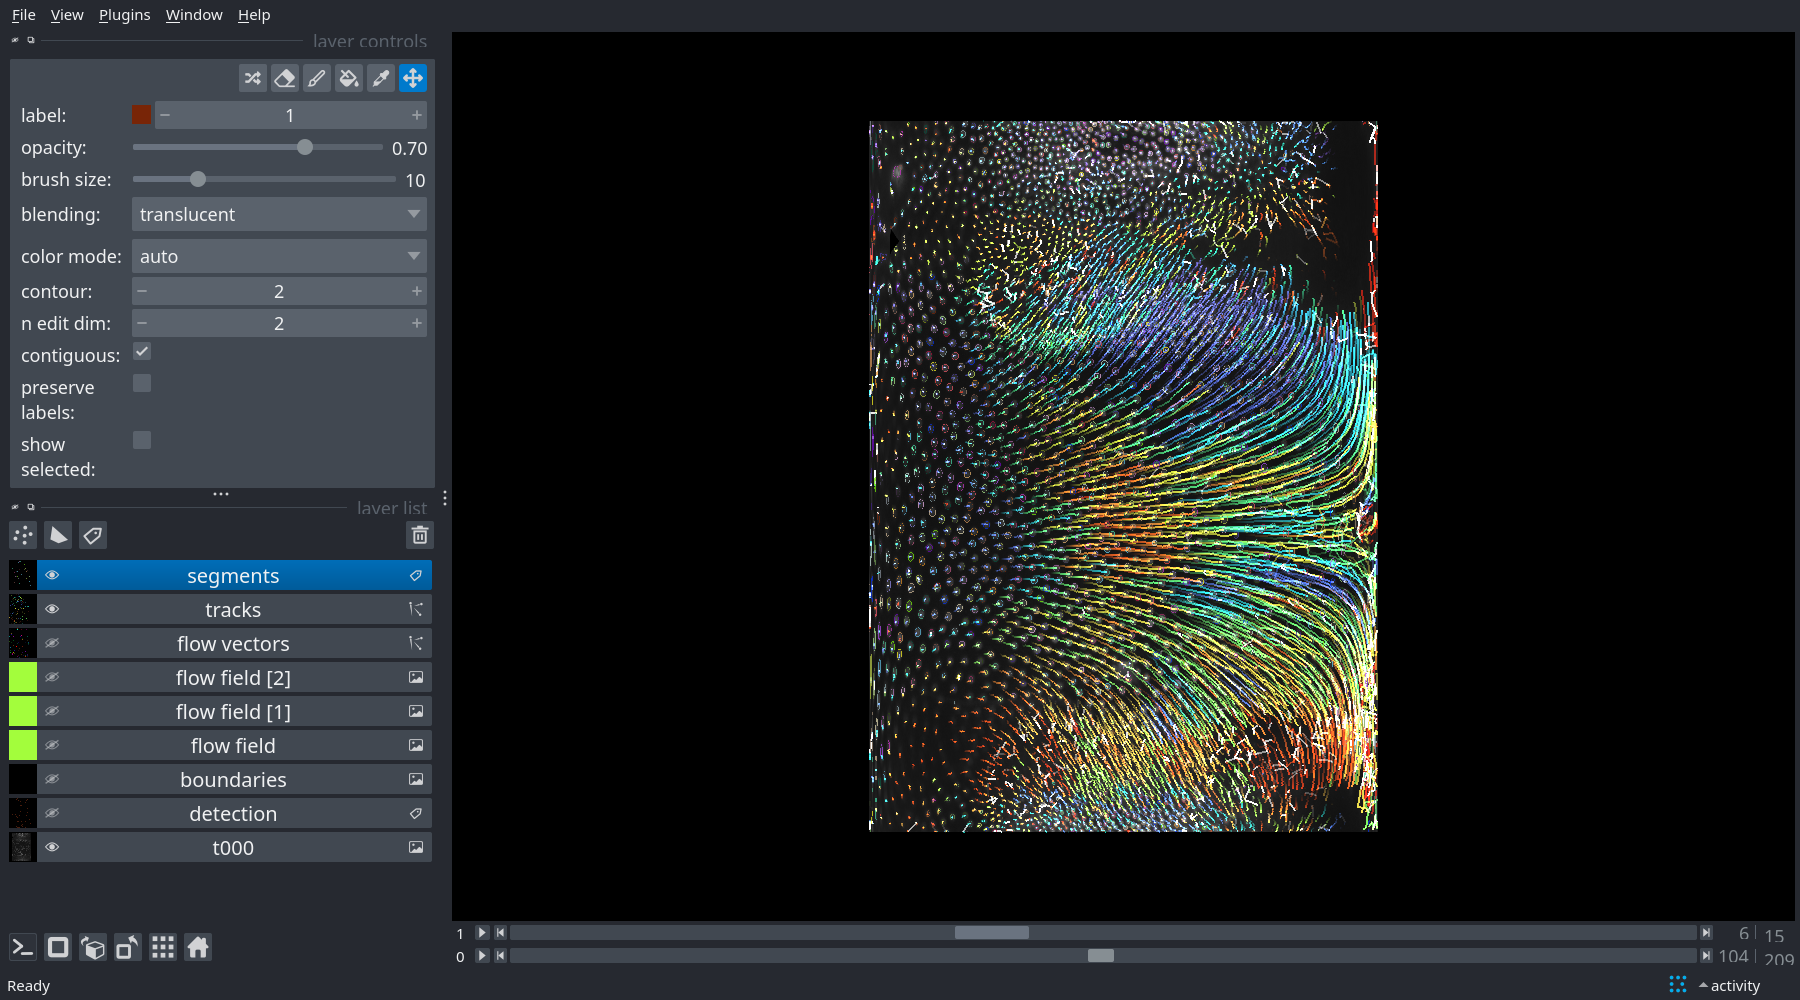

In [16]:
tracks_df, graph = to_tracks_layer(cfg)
tracks_df.to_csv("tracks.csv", index=False)

segments = tracks_to_zarr(
    cfg,
    tracks_df,
    store_or_path="segments.zarr",
    overwrite=True,
)

viewer.layers["flow vectors"].visible = False
viewer.layers["detection"].visible = False
viewer.add_tracks(
    tracks_df[["track_id", "t", "z", "y", "x"]],
    name="tracks",
    graph=graph,
    visible=True,
)

viewer.add_labels(da.from_zarr(segments), name="segments").contour = 2

nbscreenshot(viewer)